# Q2: ViT for classification

## data preprocess

In [36]:
import os
import pandas as pd
from PIL import Image
import xmltodict
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append((filename, img))
    return images

directories = {
    'neutrophil': './data/BCCD/neutrophil',
    'eosinophil': './data/BCCD/eosinophil',
    'monocyte': './data/BCCD/monocyte',
    'lymphocyte': './data/BCCD/lymphocyte'
}

data = []
for label, folder in directories.items():
    imgs = load_images_from_folder(folder)
    for img in imgs:
        data.append((label, img[0], img[1]))

df = pd.DataFrame(data, columns=['label', 'filename', 'image'])

In [90]:
def parse_bccd_annotations(annotation_file):
    with open(annotation_file) as file:
        annotations = xmltodict.parse(file.read())
    
    objects = annotations['annotation']['object']
    
    if isinstance(objects, list):
        for obj in objects:
            if obj['name'] == 'WBC':
                bbox = obj['bndbox']
                coordinates = {
                    'xmin': int(bbox['xmin']),
                    'ymin': int(bbox['ymin']),
                    'xmax': int(bbox['xmax']),
                    'ymax': int(bbox['ymax'])
                }
                return coordinates
    else:
        if objects['name'] == 'WBC':
            bbox = objects['bndbox']
            coordinates = {
                'xmin': int(bbox['xmin']),
                'ymin': int(bbox['ymin']),
                'xmax': int(bbox['xmax']),
                'ymax': int(bbox['ymax'])
            }
            return coordinates
    
    return {}


annotation_folder = './data/bccd_dataset/bccd/annotations'
annotations = {}
for filename in os.listdir(annotation_folder):
    if filename.endswith('.xml'):
        ann = parse_bccd_annotations(os.path.join(annotation_folder, filename))
        annotations[filename] = ann

df['annotation'] = df['filename'].apply(lambda x: annotations.get(x.replace('.jpg', '.xml'), None))


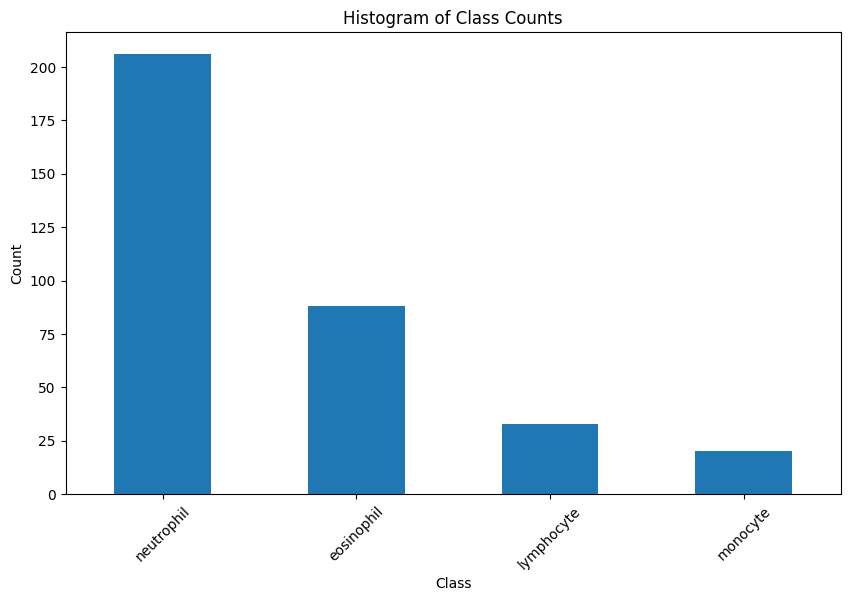

In [131]:
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [132]:
import albumentations as A
from albumentations.core.bbox_utils import convert_bboxes_to_albumentations, convert_bboxes_from_albumentations
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'])  # Use Pascal VOC format
)

In [136]:
augmented_data = []

for class_name, count in class_counts.items():
    class_samples = df[df['label'] == class_name]
    
    while sum(1 if (x['label']==class_name) else 0 for x in augmented_data)<(250 - count):
        sample = class_samples.sample(n=1).iloc[0]
        image_path = os.path.join('./data/bccd', sample['label'],sample['filename'])
        bbox = sample['annotation']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if(bbox==None or len(bbox.keys())==0):
            continue
        bboxes = [[bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']]]
        category_ids = [0]

        augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)
        
        augmented_image = augmented['image']
        augmented_bboxes = augmented['bboxes']

        for aug_bbox in augmented_bboxes:
            aug_bbox_dict = {
                "xmin": int(aug_bbox[0]),
                "ymin": int(aug_bbox[1]),
                "xmax": int(aug_bbox[2]),
                "ymax": int(aug_bbox[3]),
            }

            augmented_data.append({
                'label': class_name,
                'filename': f"aug_{len(augmented_data)}_{sample['filename']}.jpg",
                'image': augmented_image,
                'annotation': aug_bbox_dict,
            })


In [137]:
augmented_df = pd.DataFrame(augmented_data)
augmented_df = pd.concat([df, augmented_df], ignore_index=True)

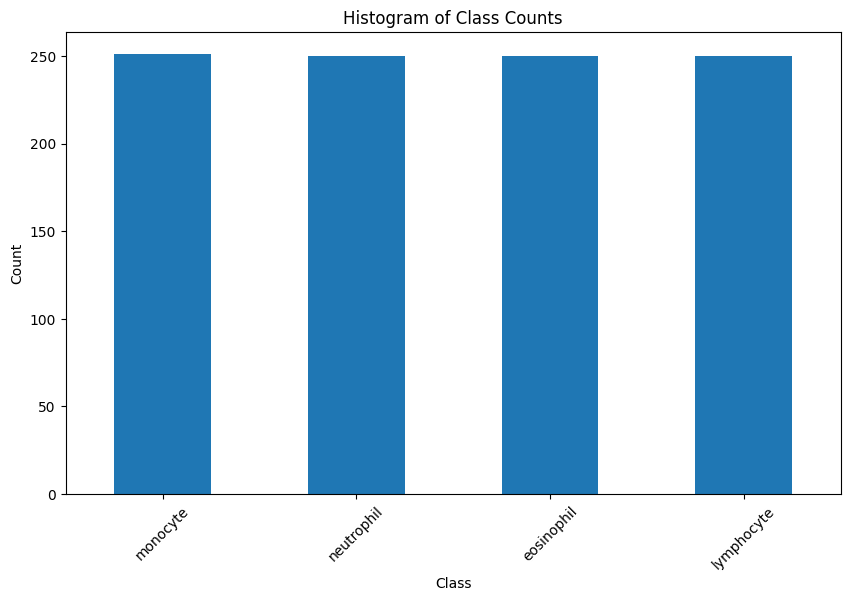

In [138]:
class_counts = augmented_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [139]:
class WBCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['image']
        annotation = self.df.iloc[idx]['annotation']
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            img = self.transform(img)
        
        return img, label, annotation

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = WBCDataset(augmented_df, transform=transform)

In [142]:
len(dataset)

1001